In [2]:
import scanpy as sc 
import anndata as ad
import polars as pl
import os
import sys
from plotting import *
from scperturb import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

## Load metadata

In [6]:
meta_celldeath = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/Single_cell_project/DP_BEACTICA/inputs/metadata/metadata_deepprofiler_beactica.csv")

In [3]:
comps = ['LOVASTATIN',
 'HS-173',
 'CISPLATIN',
 'EVEROLIMUS',
 'DOMPERIDONE',
 'ONCRASIN 1',
 'POLYPHYLLIN VI',
 'SN 38',
 'MPC 6827',
 'DOXORUBICIN',
 'BLEOMYCIN',
 'SULFASALAZINE',
 'C 75',
 'CARBOPLATIN',
 'KAEMPFEROL',
 'DACTINOMYCIN (ACTINOMYCIN D)',
 'PRAVASTATIN',
 'SMBA 1',
 'BORTEZOMIB',
 'AT 101',
 'TENIPOSIDE',
 'OXALIPLATIN',
 'OLAPARIB',
 'ETOPOSIDE',
 'SORAFENIB',
 'FIN 56',
 'ERASTIN',
 'G5',
 'SHIKONIN',
 'CLADRIBINE',
 'EPIRUBICIN',
 'AZD 2461',
 'RIFAXIMIN',
 'CAMPTOTHECIN',
 'PIMOZIDE',
 'VU0359595',
 'FK 866',
 'NARCICLASINE',
 'TOPOTECAN',
 'NIGERICIN',
 'LOPERAMIDE',
 'MITOMYCIN C',
 'DAUNORUBICIN',
 'BZ 423',
 'SIMVASTATIN',
 'L-690;330',
 'APOPTOSIS ACTIVATOR 2',
 'FLUDARABINE',
 'CRIZOTINIB',
 '2;3-DCPE HYDROCHLORIDE']

In [4]:
meta_celldeath_filter = meta_celldeath.select([ "compound_id", "Metadata_cmpdName", "moa", "Metadata_cmpdConc"]).unique()
meta_celldeath_filter = meta_celldeath_filter.with_columns(
    pl.col("Metadata_cmpdName").str.to_uppercase().alias("Metadata_cmpdName")
)
meta_celldeath_filter = meta_celldeath_filter.filter(pl.col("Metadata_cmpdName").is_in(comps))
meta_celldeath_filter = meta_celldeath_filter.with_columns(
    (pl.col("compound_id") + "_" + pl.col("Metadata_cmpdConc").cast(pl.Utf8)).alias("Metadata_cmpdIDConc")
)
meta_celldeath_filter = meta_celldeath_filter.with_columns(
    (pl.col("Metadata_cmpdName") + "_" + pl.col("Metadata_cmpdConc").cast(pl.Utf8)).alias("Metadata_cmpdNameConc")
)

In [5]:
meta_celldeath_filter_pd = meta_celldeath_filter.to_pandas()

## E test

In [11]:
etest_grit_DP = pl.DataFrame(pd.read_csv("etest_res_beactica_500_samples_50000_perms.csv"))
etest_grit_CP = pl.DataFrame(pd.read_csv("etest_res_beactica_200_samples_50000_perms_CP.csv"))
etest_grit_DINO = pd.read_csv("etest_res_beactica_200_samples_50000_perms_DINO.csv")

In [12]:
etest_grit_DINO['Unnamed: 0'] = etest_grit_DINO['Unnamed: 0'].str.replace(r'_(?=[^_]*$)', '.', regex=True)
etest_grit_DINO = pl.DataFrame(etest_grit_DINO)

In [14]:
etest_grit_DINO = etest_grit_DINO.join(meta_celldeath_filter, left_on = "Unnamed: 0", right_on = "Metadata_cmpdNameConc").to_pandas()
etest_grit_DINO.rename(columns={'Unnamed: 0': 'Metadata_cmpdNameConc'}, inplace=True)

In [15]:
etest_grit_DP = etest_grit_DP.join(meta_celldeath_filter, left_on = "Unnamed: 0", right_on = "Metadata_cmpdIDConc").to_pandas()

In [16]:
etest_grit_CP = etest_grit_CP.join(meta_celldeath_filter, left_on = "Unnamed: 0", right_on = "Metadata_cmpdNameConc").to_pandas()
etest_grit_CP.rename(columns={'Unnamed: 0': 'Metadata_cmpdNameConc'}, inplace=True)

In [17]:
true_count = etest_grit_DP[etest_grit_DP['significant_adj'] == True].shape[0]
total_count = etest_grit_DP.shape[0]


# If 'significant_adj' contains 'True'/'False' strings, you can adjust the filter like this:
true_count_str = etest_grit_DP[etest_grit_DP['significant_adj'] == 'True'].shape[0]
percentage_true_str = (true_count_str / total_count) * 100
print(f"Percentage of 'True' (string) values: {percentage_true_str:.2f}%")

Percentage of 'True' (string) values: 74.90%


In [18]:
true_count = etest_grit_CP[etest_grit_CP['significant_adj'] == True].shape[0]
total_count = etest_grit_CP.shape[0]


# If 'significant_adj' contains 'True'/'False' strings, you can adjust the filter like this:
true_count_str = etest_grit_CP[etest_grit_CP['significant_adj'] == 'True'].shape[0]
percentage_true_str = (true_count_str / total_count) * 100
print(f"Percentage of 'True' (string) values: {percentage_true_str:.2f}%")

Percentage of 'True' (string) values: 66.54%


In [19]:
true_count = etest_grit_DINO[etest_grit_DINO['significant_adj'] == True].shape[0]
total_count = etest_grit_DINO.shape[0]


# If 'significant_adj' contains 'True'/'False' strings, you can adjust the filter like this:
true_count_str = etest_grit_DINO[etest_grit_DINO['significant_adj'] == 'True'].shape[0]
percentage_true_str = (true_count_str / total_count) * 100
print(f"Percentage of 'True' (string) values: {percentage_true_str:.2f}%")

Percentage of 'True' (string) values: 86.62%


In [20]:
etest_grit_CP['tmp'] = np.log10(np.clip(etest_grit_CP['edist'], 0, np.inf)+1)
etest_grit_DP['tmp'] = np.log10(np.clip(etest_grit_DP['edist'], 0, np.inf)+1)
etest_grit_DINO['tmp'] = np.log10(np.clip(etest_grit_DINO['edist'], 0, np.inf)+1)

In [21]:
def e_dist_violin_sign(estats, condition, sign = False):
    estats = estats[estats["Metadata_cmpdName"] != "DIMETHYL SULFOXIDE"]
    scale=0.75
    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(figsize=[20*scale, 5*scale], dpi=300)
    # np.log10(estats_control['E-statistic']+1)
    sns.violinplot(data=estats, x='tmp', inner=None, color=".8", width=0.8, bw=0.5)
    if sign:
        ax = sns.swarmplot(data=estats, x=estats['tmp'], y=['']*len(estats), size=10, marker='$\mathbf{\odot}$',
                    edgecolor='white', linewidth=0, hue = "significant_adj",palette=['tab:blue', 'tab:red', 'tab::orange'])
        
    else:
        ax = sns.swarmplot(data=estats, x=estats['tmp'], y=['']*len(estats), size=10, marker='$\mathbf{\odot}$',
                    edgecolor='white', linewidth=0, palette=['tab:blue', 'tab:red'])
    plt.xlabel('E-distance+1 to unperturbed (log scale)')
    ax.axvline(0, c='grey', linestyle='--', linewidth=4)
    # log scale x ticks
    from matplotlib import ticker as mticker
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    xmin, xmax = ax.get_xlim()
    tick_range = np.arange(0, xmax)
    ax.xaxis.set_ticks(tick_range)
    ax.xaxis.set_ticks([np.log10(x+1) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    ax.set_xlim([-1, 5.5])
    if sign:
        plt.savefig(f'e_dist_violin_{condition}_sign_lev.png', bbox_inches='tight')
    else:
        plt.savefig(f'e_dist_violin_{condition}.png', bbox_inches='tight')
    plt.show()

/tmp/ipykernel_1020724/171018577.py:7: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=estats, x='tmp', inner=None, color=".8", width=0.8, bw=0.5)
/tmp/ipykernel_1020724/171018577.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.swarmplot(data=estats, x=estats['tmp'], y=['']*len(estats), size=10, marker='$\mathbf{\odot}$',
/home/jovyan/share/data/analyses/benjamin/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


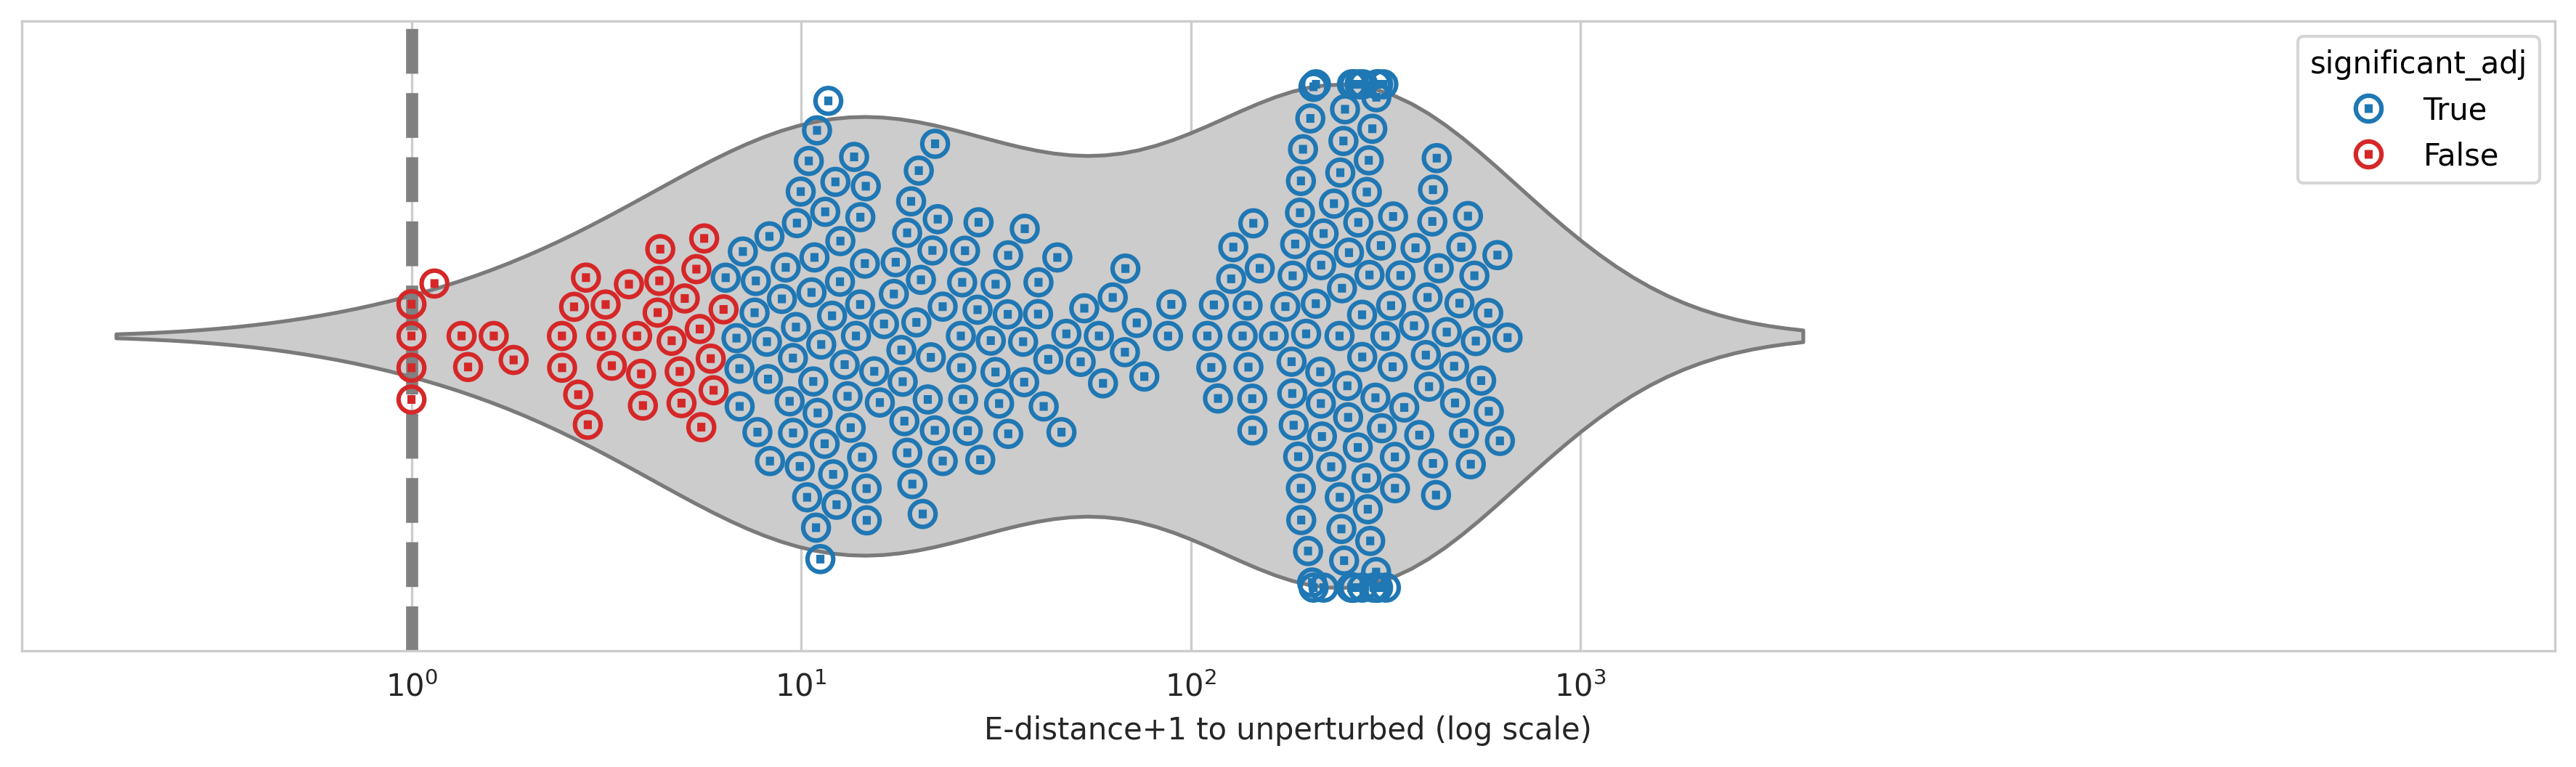

In [22]:
e_dist_violin_sign(etest_grit_DINO, "full_grit_DINO", sign = True)

In [ ]:
e_dist_violin_sign(etest_grit_CP, "full_grit_CP", sign = True) #adjust scale
e_dist_violin_sign(etest_grit_DP, "full_grit_DP", sign = True) #adjust scale

In [78]:
def scatter_plot_comparison_matching(df1, df2, x_col="tmp", y_col="tmp", merge_col="Metadata_cmpdNameConc"):
    # Perform an inner join based on the 'Metadata_cmpdNameConc' column
    merged_df = pd.merge(df1, df2, on=merge_col, suffixes=('_df1', '_df2'))

    # Count non-matching rows from each DataFrame
    non_matching_df1 = df1[~df1[merge_col].isin(merged_df[merge_col])]
    non_matching_df2 = df2[~df2[merge_col].isin(merged_df[merge_col])]

    # Print the number of non-matching rows
    print(f"Number of non-matching rows in df1: {len(non_matching_df1)}")
    print(f"Number of non-matching rows in df2: {len(non_matching_df2)}")

    # Calculate the residuals as the difference between the two values (y - x)
    merged_df['comparison'] = np.where(merged_df[f'{y_col}_df2'] > merged_df[f'{x_col}_df1'], 'higher in DP', 'higher in CP')

    # Plot scatter plot with custom labels for higher values
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        data=merged_df, 
        x=f'{x_col}_df1', 
        y=f'{y_col}_df2', 
        hue='comparison', 
        palette={'higher in DP': 'red', 'higher in CP': 'blue'}
    )

    # Add y = x line (identity line)
    max_val = max(merged_df[f'{x_col}_df1'].max(), merged_df[f'{y_col}_df2'].max())
    plt.plot([0, max_val], [0, max_val], color='green', linestyle='--', label='y = x')

    # Add labels and title
    plt.xlabel(f'log(edist+1) CP')
    plt.ylabel(f'log(edist+1) DP')
    plt.legend()

    # Show plot
    plt.show()
# Example usage:
# scatter_plot_comparison_matching(df1, df2, x_col="tmp", y_col="tmp", merge_col="Metadata_cmpdNameConc")


Number of non-matching rows in df1: 0
Number of non-matching rows in df2: 9


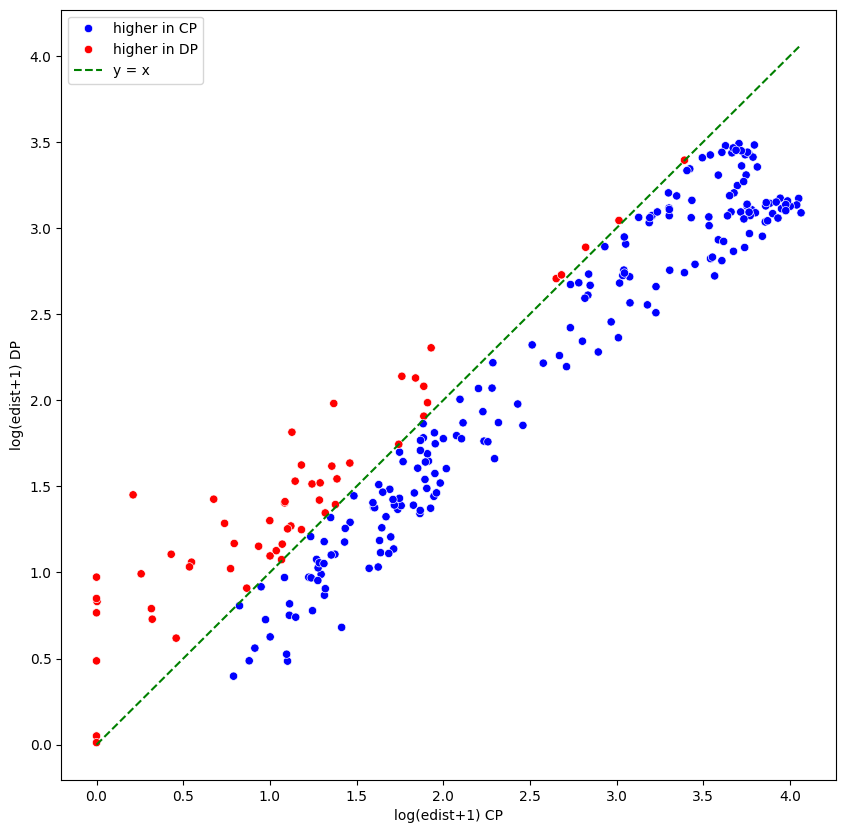

In [79]:
scatter_plot_comparison_matching(etest_grit_CP, etest_grit_DP)


## Grit analysis

In [6]:
cp_grit = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/grit_all_cmpdconc_beactica_CP.csv")
dp_grit = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/grit_all_cmpdconc_beactica_DP.csv")
DINO_grit = pl.read_csv("/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/datasets_paper/grit_all_cmpdconc_beactica_DINO.csv")

In [7]:
DINO_grit = DINO_grit.join(meta_celldeath_filter, left_on = "group", right_on = "Metadata_cmpdNameConc")
cp_grit = cp_grit.join(meta_celldeath_filter, left_on = "group", right_on = "Metadata_cmpdNameConc")
dp_grit = dp_grit.join(meta_celldeath_filter, left_on = "group", right_on = "Metadata_cmpdNameConc")

In [10]:
(cp_grit.filter(pl.col('grit') > 1.5).height/ cp_grit['grit'].len()) * 100

54.0268456375839

In [11]:
(dp_grit.filter(pl.col('grit') > 1.5).height/ dp_grit['grit'].len()) * 100

53.42960288808665

In [12]:
(DINO_grit.filter(pl.col('grit') > 1.5).height/ DINO_grit['grit'].len()) * 100

53.76712328767124

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

def grit_dist(estats, sign=False):
    # Use Polars' filter method instead of boolean indexing
    estats = estats.filter(pl.col("group") != "DIMETHYL SULFOXIDE")
    scale = 0.75
    
    # Add a column to color based on grit value
    estats = estats.with_columns(
        pl.when(pl.col('grit') < 1.5)  # Color below 1.5 as red
        .then(pl.lit('tab:red'))
        .otherwise(pl.lit('tab:blue'))     # Color above 1.5 as blue
        .alias('color')
    )
    
    # Convert Polars DataFrame to Pandas for Seaborn
    estats_pd = estats.to_pandas()
    
    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(figsize=[20 * scale, 10 * scale], dpi=300)

    # Violin plot based on the 'grit' column, using the updated bw_adjust
    sns.violinplot(data=estats_pd, x='grit', inner=None, color=".8", width=0.8, bw_adjust=0.5, ax=ax)

    # Swarm plot with conditional coloring using `hue`
    sns.swarmplot(data=estats_pd, x='grit', y=[''] * len(estats_pd), size=10, 
                  marker='$\mathbf{\odot}$', edgecolor='white', linewidth=0, hue='color', palette=['tab:red', 'tab:blue'], legend=False, ax=ax)
    
    # Vertical line at grit = 1.5
    ax.axvline(1.5, c='black', linestyle='--', linewidth=1.5)
    
    # Set the x-axis label
    plt.xlabel('Grit distribution DINO', fontsize = 16 )
    
    # Remove the powers of 10 and set plain x-ticks
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    
    # Set x-axis limits (adjust as necessary)
    ax.set_xlim([-2, 25])
    
    # Save the figure with or without 'sign' option
    if sign:
        plt.savefig(f'/home/jovyan/share/data/analyses/benjamin/DINO/CELLDEATH/figures/grit_dist_DINO.png', bbox_inches='tight')
    
    # Show the plot
    plt.show()

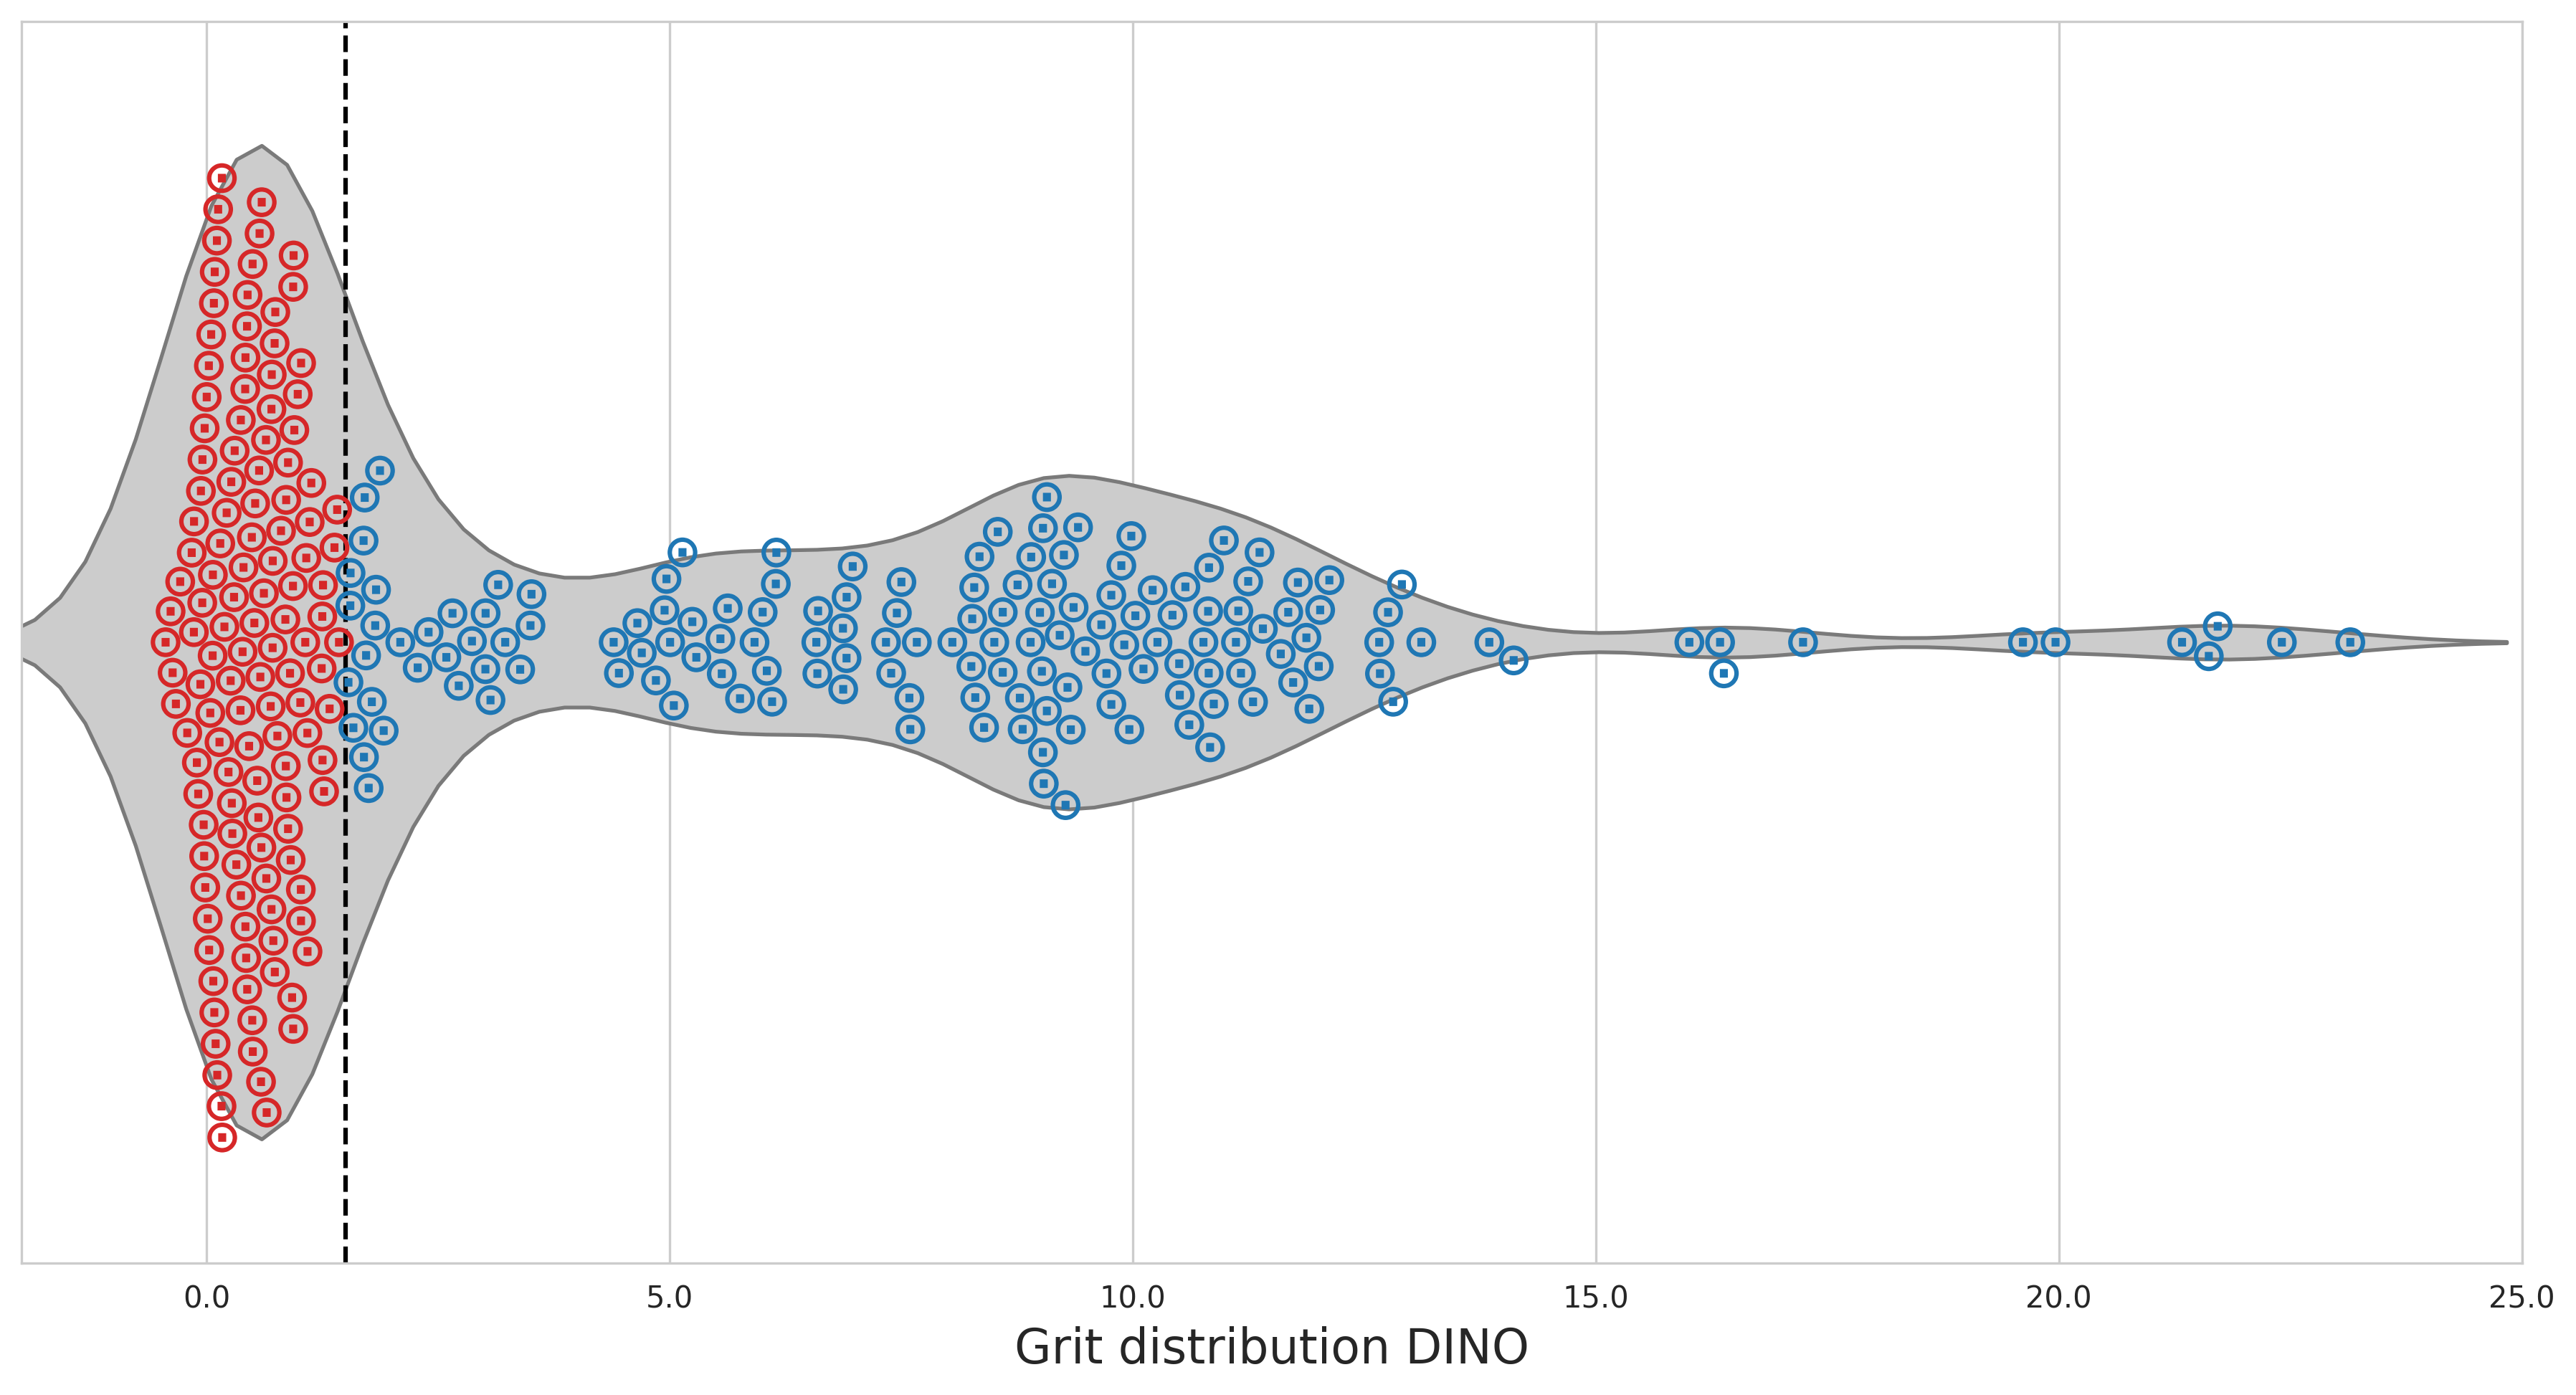

In [19]:
grit_dist(DINO_grit, sign = True)

In [ ]:
grit_dist(CP_grit, sign = True) #adjust scale
grit_dist(DP_grit, sign = True) #adjust scale

## Compare sets

In [29]:
set1_grit = set(DINO_grit.filter(pl.col("grit") > 1.5)['group'])
set2_grit = set(dp_grit.filter(pl.col("grit") > 1.5)['group'])
set3_grit = set(cp_grit.filter(pl.col("grit") > 1.5)['group'])
# Signficant etest
set1_etest = set(etest_grit_DINO[etest_grit_DINO['significant_adj'] == "True"]['Metadata_cmpdNameConc'])
set2_etest = set(etest_grit_DP[etest_grit_DP['significant_adj'] == "True"]['Metadata_cmpdNameConc'])
set3_etest = set(etest_grit_CP[etest_grit_CP['significant_adj'] == "True"]['Metadata_cmpdNameConc'])

In [31]:
import csv
# Sample data: Replace these with your actual sets

# Combine all sets into a list
data = [list(set3_grit), list(set2_grit), list(set1_grit), list(set3_etest), list(set2_etest), list(set1_etest)]

# Determine the maximum length of the sets
max_len = max(len(s) for s in data)

# Normalize the length of each set by padding with empty strings
normalized_data = [s + [''] * (max_len - len(s)) for s in data]

# Transpose the data to match the desired format
transposed_data = list(zip(*normalized_data))

# Specify the column names
columns = ['grit_cp', 'grit_dp', 'grit_dino', 'etest_cp', 'etest_dp', 'etest_dino']

# Write the data to a CSV file
output_file = "compound_plot_data.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(columns)  # Write the header
    writer.writerows(transposed_data)


CSV file 'compound_plot_data.csv' has been created successfully.


## Etest venn

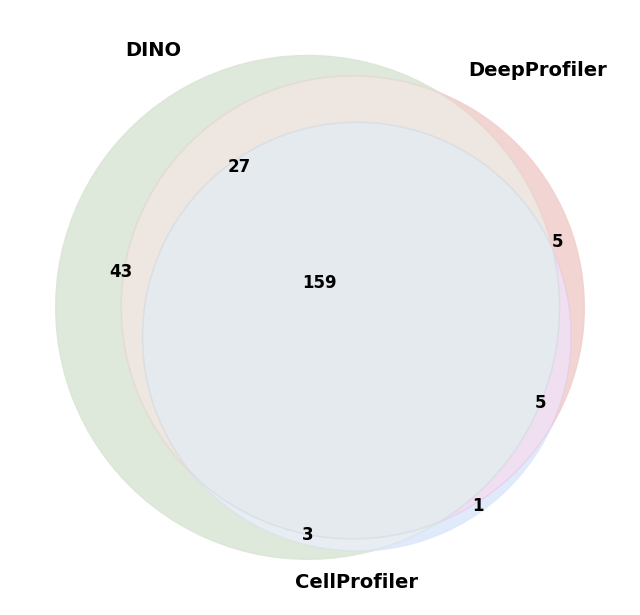

In [35]:
color1 = '#DBE6D7'  # Pastel green
color2 = '#F1D0CD'  # Pastel pink
color3 = '#DDE8FA'  # Pastel blue

# Create the Venn diagram with the specified colors, transparency, and line width
plt.figure(figsize=(8, 8))
venn = venn3(
    [set1_etest, set2_etest, set3_etest], 
    set_labels=('DINO', 'DeepProfiler', 'CellProfiler')
)
# Assign colors to individual patches
if venn.get_patch_by_id('100'):  # Only in Set 1
    venn.get_patch_by_id('100').set_color(color1)
    venn.get_patch_by_id('100').set_alpha(0.9)

if venn.get_patch_by_id('010'):  # Only in Set 2
    venn.get_patch_by_id('010').set_color(color2)
    venn.get_patch_by_id('010').set_alpha(0.9)

if venn.get_patch_by_id('001'):  # Only in Set 3
    venn.get_patch_by_id('001').set_color(color3)
    venn.get_patch_by_id('001').set_alpha(0.9)

# Assign blended colors to intersections
if venn.get_patch_by_id('110'):  # Intersection of Set 1 and Set 2
    venn.get_patch_by_id('110').set_color('#E6D9D2')  # Blended pink and green
    venn.get_patch_by_id('110').set_alpha(0.65)

if venn.get_patch_by_id('101'):  # Intersection of Set 1 and Set 3
    venn.get_patch_by_id('101').set_color('#DBE4EB')  # Blended green and blue
    venn.get_patch_by_id('101').set_alpha(0.65)

if venn.get_patch_by_id('011'):  # Intersection of Set 2 and Set 3
    venn.get_patch_by_id('011').set_color('#E7CFEA')  # Blended pink and blue
    venn.get_patch_by_id('011').set_alpha(0.65)

if venn.get_patch_by_id('111'):  # Intersection of all three sets
    venn.get_patch_by_id('111').set_color('#D7DFE6')  # Blended of all three colors
    venn.get_patch_by_id('111').set_alpha(0.65)
# Customize labels
for text in venn.set_labels:
    text.set_fontsize(14)
    text.set_fontweight('bold')

# Customize subset labels (numbers inside the diagram)
for text in venn.subset_labels:
    if text:
        text.set_fontsize(12)
        text.set_fontweight('bold')

# Show the plot
plt.show()

# Grit venn

In [ ]:
color1 = '#DBE6D7'  # Pastel green
color2 = '#F1D0CD'  # Pastel pink
color3 = '#DDE8FA'  # Pastel blue

# Create the Venn diagram with the specified colors, transparency, and line width
plt.figure(figsize=(8, 8))
venn = venn3(
    [set1_grit, set2_grit, set3_grit], 
    set_labels=('DINO', 'DeepProfiler', 'CellProfiler')
)
# Assign colors to individual patches
if venn.get_patch_by_id('100'):  # Only in Set 1
    venn.get_patch_by_id('100').set_color(color1)
    venn.get_patch_by_id('100').set_alpha(0.9)

if venn.get_patch_by_id('010'):  # Only in Set 2
    venn.get_patch_by_id('010').set_color(color2)
    venn.get_patch_by_id('010').set_alpha(0.9)

if venn.get_patch_by_id('001'):  # Only in Set 3
    venn.get_patch_by_id('001').set_color(color3)
    venn.get_patch_by_id('001').set_alpha(0.9)

# Assign blended colors to intersections
if venn.get_patch_by_id('110'):  # Intersection of Set 1 and Set 2
    venn.get_patch_by_id('110').set_color('#E6D9D2')  # Blended pink and green
    venn.get_patch_by_id('110').set_alpha(0.65)

if venn.get_patch_by_id('101'):  # Intersection of Set 1 and Set 3
    venn.get_patch_by_id('101').set_color('#DBE4EB')  # Blended green and blue
    venn.get_patch_by_id('101').set_alpha(0.65)

if venn.get_patch_by_id('011'):  # Intersection of Set 2 and Set 3
    venn.get_patch_by_id('011').set_color('#E7CFEA')  # Blended pink and blue
    venn.get_patch_by_id('011').set_alpha(0.65)

if venn.get_patch_by_id('111'):  # Intersection of all three sets
    venn.get_patch_by_id('111').set_color('#D7DFE6')  # Blended of all three colors
    venn.get_patch_by_id('111').set_alpha(0.65)
# Customize labels
for text in venn.set_labels:
    text.set_fontsize(14)
    text.set_fontweight('bold')

# Customize subset labels (numbers inside the diagram)
for text in venn.subset_labels:
    if text:
        text.set_fontsize(12)
        text.set_fontweight('bold')

# Show the plot
plt.show()